In [1]:
import sys

def change_python_version(pv):
    
    if "/lib" in pv:
        pv = pv.replace("/lib", "/envs/shoe_ml_evaluator/lib")
    
    if "python36" in pv:
        pv = pv.replace("python36", "python37")
    elif "python3.6" in pv:
        pv = pv.replace("python3.6", "python3.7")

    return pv

updated_path = list(map(change_python_version, sys.path))
sys.path.extend(updated_path)

In [2]:
import cv2
import glob
from joblib import dump,load
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import webcolors

In [3]:
df = pd.read_csv("../data/browse_api_product_info.csv")

In [5]:
df = df[["brand", "category", "colorway", "gender", "title", "averageDeadstockPrice", "deadstockSold", "imageUrl", "pricePremium"]]

In [6]:
df

,brand,category,colorway,gender,title,averageDeadstockPrice,deadstockSold,imageUrl,pricePremium
0,adidas,adidas Yeezy,Cream White/Cream White,men,adidas Yeezy Boost 350 V2 Cream/Triple White,210,44325,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.855
1,adidas,adidas Yeezy,White/Core Black/Red,men,adidas Yeezy Boost 350 V2 Zebra,261,38747,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.950
2,adidas,adidas Yeezy,Solid Grey/Chalk White/Core Black,men,adidas Yeezy Boost 700 Wave Runner Solid Grey,323,33708,https://stockx.imgix.net/Adidas-Yeezy-Wave-Run...,0.707
3,adidas,adidas Yeezy,Semi Frozen Yellow/Raw Steel/Red,men,adidas Yeezy Boost 350 V2 Semi Frozen Yellow,233,21305,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.426
4,adidas,adidas Yeezy,Blue Tint/Grey Three/High Risk Red,men,adidas Yeezy Boost 350 V2 Blue Tint,307,11207,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.709
5,adidas,adidas Yeezy,Grey/Bold Orange/Dark Grey,men,adidas Yeezy Boost 350 V2 Beluga 2.0,346,10634,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,1.182
6,adidas,adidas Ultra Boost,Running White/Running White/Running White,men,adidas Ultra Boost 4.0 Running White,102,7503,https://stockx.imgix.net/Adidas-Ultra-Boost-4-...,-0.250
7,Jordan,Air Jordan Eleven,Gym Red/Black-White,men,Jordan 11 Retro Win Like 96,199,5274,https://stockx.imgix.net/Air-Jordan-11-Retro-W...,0.132
8,Jordan,Air Jordan One,Black/Varsity Royal-White,men,Jordan 1 Retro Royal (2017),216,5029,https://stockx.imgix.net/Air-Jordan-1-Retro-Bl...,0.500
9,Jordan,Air Jordan Eleven,White/University Blue-Midnight Navy,men,Jordan 11 Retro UNC Win Like 82,177,4185,https://stockx.imgix.net/Air-Jordan-11-Retro-M...,0.091


In [7]:
def find_colours(colorway):
    
    colours = " ".join(colorway.lower().split("/")).split(" ")
    
    unique_colours = list(set([colour_str for colour_str in colours if colour_str in webcolors.CSS3_NAMES_TO_HEX]))
    
    return sorted(unique_colours)

df["uniqueColours"] = df["colorway"].apply(find_colours)

In [8]:
df.head()

,brand,category,colorway,gender,title,averageDeadstockPrice,deadstockSold,imageUrl,pricePremium,uniqueColours
0,adidas,adidas Yeezy,Cream White/Cream White,men,adidas Yeezy Boost 350 V2 Cream/Triple White,210,44325,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.855,[white]
1,adidas,adidas Yeezy,White/Core Black/Red,men,adidas Yeezy Boost 350 V2 Zebra,261,38747,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.950,"[black, red, white]"
2,adidas,adidas Yeezy,Solid Grey/Chalk White/Core Black,men,adidas Yeezy Boost 700 Wave Runner Solid Grey,323,33708,https://stockx.imgix.net/Adidas-Yeezy-Wave-Run...,0.707,"[black, grey, white]"
3,adidas,adidas Yeezy,Semi Frozen Yellow/Raw Steel/Red,men,adidas Yeezy Boost 350 V2 Semi Frozen Yellow,233,21305,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.426,"[red, yellow]"
4,adidas,adidas Yeezy,Blue Tint/Grey Three/High Risk Red,men,adidas Yeezy Boost 350 V2 Blue Tint,307,11207,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.709,"[blue, grey, red]"


In [9]:
# Entries where matching colour has not been found
df[df['uniqueColours'].map(lambda d: len(d)) == 0].shape

(35, 10)

In [10]:
mlb = MultiLabelBinarizer()
unique_colour_labels = mlb.fit_transform(df['uniqueColours'])
df = df.join(pd.DataFrame(unique_colour_labels, columns=mlb.classes_))
df.drop(["uniqueColours"], axis=1, inplace=True)
df.head()

,brand,category,colorway,gender,title,averageDeadstockPrice,deadstockSold,imageUrl,pricePremium,aqua,...,orange,pink,purple,red,silver,tan,teal,violet,white,yellow
0,adidas,adidas Yeezy,Cream White/Cream White,men,adidas Yeezy Boost 350 V2 Cream/Triple White,210,44325,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.855,0,...,0,0,0,0,0,0,0,0,1,0
1,adidas,adidas Yeezy,White/Core Black/Red,men,adidas Yeezy Boost 350 V2 Zebra,261,38747,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.950,0,...,0,0,0,1,0,0,0,0,1,0
2,adidas,adidas Yeezy,Solid Grey/Chalk White/Core Black,men,adidas Yeezy Boost 700 Wave Runner Solid Grey,323,33708,https://stockx.imgix.net/Adidas-Yeezy-Wave-Run...,0.707,0,...,0,0,0,0,0,0,0,0,1,0
3,adidas,adidas Yeezy,Semi Frozen Yellow/Raw Steel/Red,men,adidas Yeezy Boost 350 V2 Semi Frozen Yellow,233,21305,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.426,0,...,0,0,0,1,0,0,0,0,0,1
4,adidas,adidas Yeezy,Blue Tint/Grey Three/High Risk Red,men,adidas Yeezy Boost 350 V2 Blue Tint,307,11207,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.709,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
cols_to_rename = {col: f"colour_{col}" for col in df.columns[9:]}
df.rename(index=str, columns=cols_to_rename, inplace=True)
df.columns

Index(['brand', 'category', 'colorway', 'gender', 'title',
       'averageDeadstockPrice', 'deadstockSold', 'imageUrl', 'pricePremium',
       'colour_aqua', 'colour_beige', 'colour_black', 'colour_blue',
       'colour_brown', 'colour_coral', 'colour_crimson', 'colour_gold',
       'colour_goldenrod', 'colour_green', 'colour_grey', 'colour_indigo',
       'colour_ivory', 'colour_khaki', 'colour_linen', 'colour_navy',
       'colour_olive', 'colour_orange', 'colour_pink', 'colour_purple',
       'colour_red', 'colour_silver', 'colour_tan', 'colour_teal',
       'colour_violet', 'colour_white', 'colour_yellow'],
      dtype='object')

In [12]:
def encode_categorical_features(df, category):
    
    encoded = pd.get_dummies(df[category], prefix=category)
    
    df = df.join(encoded)
    df.drop([category], axis=1, inplace=True)
    return df

In [13]:
for category in ["brand", "category", "gender"]:
    df = encode_categorical_features(df, category)

In [14]:
df.head()

,colorway,title,averageDeadstockPrice,deadstockSold,imageUrl,pricePremium,colour_aqua,colour_beige,colour_black,colour_blue,...,category_adidas NMD,category_adidas Other,category_adidas Stan Smith,category_adidas Ultra Boost,category_adidas Yeezy,gender_child,gender_infant,gender_men,gender_preschool,gender_women
0,Cream White/Cream White,adidas Yeezy Boost 350 V2 Cream/Triple White,210,44325,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.855,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,White/Core Black/Red,adidas Yeezy Boost 350 V2 Zebra,261,38747,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.950,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,Solid Grey/Chalk White/Core Black,adidas Yeezy Boost 700 Wave Runner Solid Grey,323,33708,https://stockx.imgix.net/Adidas-Yeezy-Wave-Run...,0.707,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,Semi Frozen Yellow/Raw Steel/Red,adidas Yeezy Boost 350 V2 Semi Frozen Yellow,233,21305,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.426,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,Blue Tint/Grey Three/High Risk Red,adidas Yeezy Boost 350 V2 Blue Tint,307,11207,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.709,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [15]:
cols = list(df.columns.values)
cols.pop(cols.index("deadstockSold"))
df = df[cols+["deadstockSold"]]

In [16]:
df.head()

,colorway,title,averageDeadstockPrice,imageUrl,pricePremium,colour_aqua,colour_beige,colour_black,colour_blue,colour_brown,...,category_adidas Other,category_adidas Stan Smith,category_adidas Ultra Boost,category_adidas Yeezy,gender_child,gender_infant,gender_men,gender_preschool,gender_women,deadstockSold
0,Cream White/Cream White,adidas Yeezy Boost 350 V2 Cream/Triple White,210,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.855,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,44325
1,White/Core Black/Red,adidas Yeezy Boost 350 V2 Zebra,261,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.950,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,38747
2,Solid Grey/Chalk White/Core Black,adidas Yeezy Boost 700 Wave Runner Solid Grey,323,https://stockx.imgix.net/Adidas-Yeezy-Wave-Run...,0.707,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,33708
3,Semi Frozen Yellow/Raw Steel/Red,adidas Yeezy Boost 350 V2 Semi Frozen Yellow,233,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.426,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,21305
4,Blue Tint/Grey Three/High Risk Red,adidas Yeezy Boost 350 V2 Blue Tint,307,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,0.709,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,11207


In [17]:
df.drop(["colorway", "title", "imageUrl"], axis=1, inplace=True)

In [18]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
X_train.loc[:,"averageDeadstockPrice"] = MinMaxScaler().fit_transform(X_train["averageDeadstockPrice"].values.reshape(-1, 1))
X_test.loc[:,"averageDeadstockPrice"] = MinMaxScaler().fit_transform(X_test["averageDeadstockPrice"].values.reshape(-1, 1))

/Users/Tom/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
X_train.head()

,averageDeadstockPrice,pricePremium,colour_aqua,colour_beige,colour_black,colour_blue,colour_brown,colour_coral,colour_crimson,colour_gold,...,category_adidas NMD,category_adidas Other,category_adidas Stan Smith,category_adidas Ultra Boost,category_adidas Yeezy,gender_child,gender_infant,gender_men,gender_preschool,gender_women
225,0.033349,-0.132,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
94,0.015500,-0.286,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
462,0.044152,1.367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
284,0.017379,-0.635,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
23,0.050728,0.047,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
y_train.head()

225     796
94      145
462     197
284     499
23     1674
Name: deadstockSold, dtype: int64

In [22]:
df.columns.values

array(['averageDeadstockPrice', 'pricePremium', 'colour_aqua',
       'colour_beige', 'colour_black', 'colour_blue', 'colour_brown',
       'colour_coral', 'colour_crimson', 'colour_gold', 'colour_goldenrod',
       'colour_green', 'colour_grey', 'colour_indigo', 'colour_ivory',
       'colour_khaki', 'colour_linen', 'colour_navy', 'colour_olive',
       'colour_orange', 'colour_pink', 'colour_purple', 'colour_red',
       'colour_silver', 'colour_tan', 'colour_teal', 'colour_violet',
       'colour_white', 'colour_yellow', 'brand_Balenciaga',
       'brand_Converse', 'brand_Diadora', 'brand_Jordan',
       'brand_New Balance', 'brand_Nike', 'brand_Puma', 'brand_Reebok',
       'brand_Revenge X Storm', 'brand_Under Armour', 'brand_Vans',
       'brand_adidas', 'category_Air Force One',
       'category_Air Jordan Eight', 'category_Air Jordan Eleven',
       'category_Air Jordan Fifteen', 'category_Air Jordan Five',
       'category_Air Jordan Four', 'category_Air Jordan Nine',
       '

In [23]:
# X_train.loc[:,"averageDeadstockPrice"] = MinMaxScaler().fit_transform(X_train["averageDeadstockPrice"].values.reshape(-1, 1))

In [24]:
dump(df, "df.joblib")
dump(X_train, "X_train.joblib")
dump(y_train, "y_train.joblib")
dump(X_test, "X_test.joblib")
dump(y_test, "y_test.joblib")

['y_test.joblib']

In [25]:
df.head()

,averageDeadstockPrice,pricePremium,colour_aqua,colour_beige,colour_black,colour_blue,colour_brown,colour_coral,colour_crimson,colour_gold,...,category_adidas Other,category_adidas Stan Smith,category_adidas Ultra Boost,category_adidas Yeezy,gender_child,gender_infant,gender_men,gender_preschool,gender_women,deadstockSold
0,210,0.855,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,44325
1,261,0.950,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,38747
2,323,0.707,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,33708
3,233,0.426,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,21305
4,307,0.709,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,11207


In [30]:
import seaborn as sns

%matplotlib inline

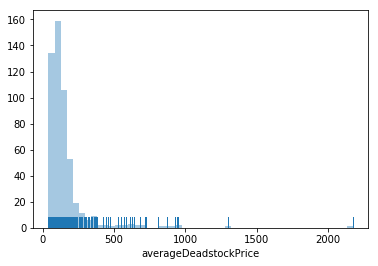

In [31]:
sns.distplot(df["averageDeadstockPrice"], kde=False, rug=True)

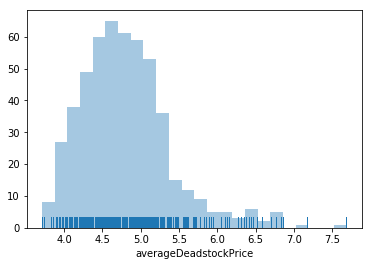

In [36]:
sns.distplot(df["averageDeadstockPrice"].apply(np.log), kde=False, rug=True)

In [34]:
print("df[\"averageDeadstockPrice\"].min()", df["averageDeadstockPrice"].min())
print("df[\"averageDeadstockPrice\"].max()", df["averageDeadstockPrice"].max())

df["averageDeadstockPrice"].min() 41
df["averageDeadstockPrice"].max() 2175


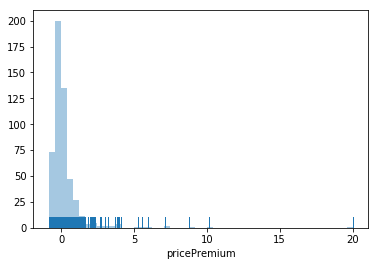

In [32]:
sns.distplot(df["pricePremium"], kde=False, rug=True)

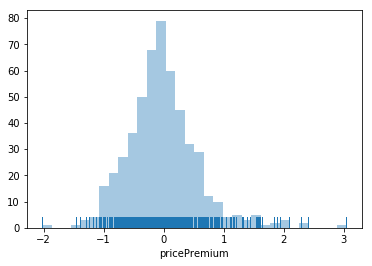

In [38]:
sns.distplot(df["pricePremium"].apply(lambda p: np.log(p+1)), kde=False, rug=True)

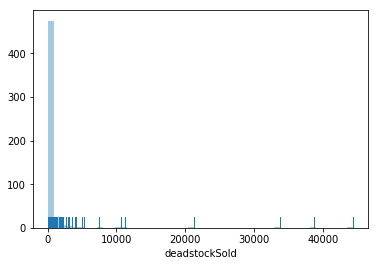

In [33]:
sns.distplot(df["deadstockSold"], kde=False, rug=True)

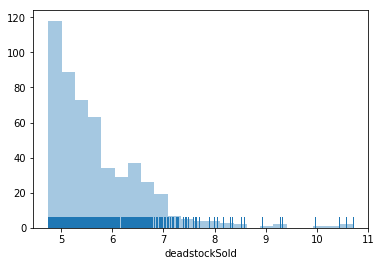

In [39]:
sns.distplot(df["deadstockSold"].apply(lambda p: np.log(p+1)), kde=False, rug=True)